# Notebook for Comparing the Model Outputs

This notebook serves as a dashboard for comparing the outputs of the dense autoencoder model (notebook 02), and the LSTM autoencoder model (notebook 02b) for anomaly detection. 

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import sys
sys.path.append("../")

from scripts.utils import get_project_path
from scripts.error_analysis import load_model_outputs, analyze_model

## Load Evaluation Outputs

In [2]:
model_dirs = {
    "Dense Autoencoder": get_project_path("models", "autoencoder"),
    "LSTM Autoencoder": get_project_path("models", "lstm")
}

records = []
model_outputs = {}
for model_name, model_dir in model_dirs.items():
    with open(os.path.join(model_dir, "metrics.json")) as f:
        metrics = json.load(f)
    records.append({"Model": model_name, **metrics})

    # load predictions
    recon_error = np.load(os.path.join(model_dir, "recon_error.npy"))
    y_true = np.load(os.path.join(model_dir, "y_true.npy"))
    model_outputs[model_name] = {
        "recon_error": recon_error,
        "y_true": y_true,
        "threshold": metrics["best_thresh"]
    }

## Summary Table

In [3]:
df_metrics = pd.DataFrame(records)
display(df_metrics.set_index("Model"))

,roc_auc,pr_auc,best_f1,best_thresh
Model,,,,
Dense Autoencoder,0.995354,0.992087,0.961455,0.138756
LSTM Autoencoder,0.603872,0.141705,0.347826,0.207574


## Comparison of Evaluation Metrics

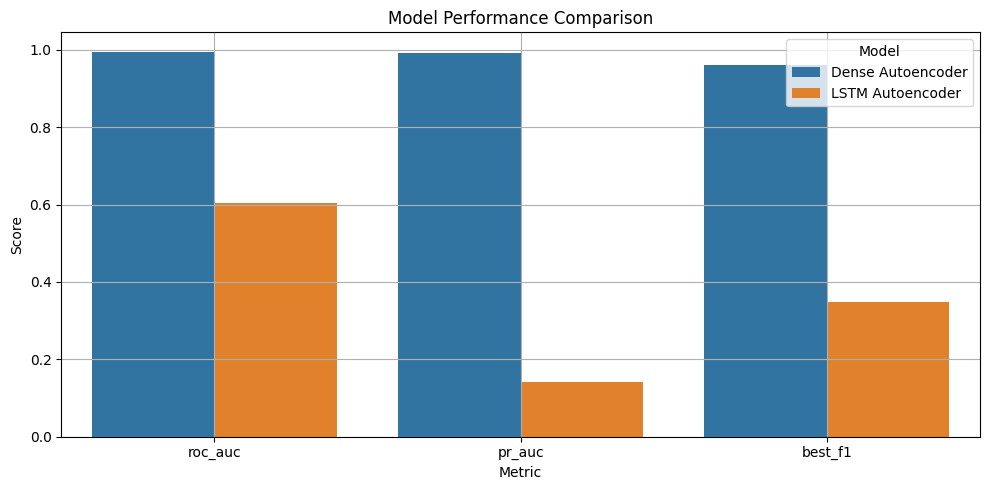

In [4]:
plt.figure(figsize = (10,5))
df_melt = df_metrics.melt(id_vars = "Model", value_vars = ["roc_auc", "pr_auc", "best_f1"])
sns.barplot(data = df_melt, x = "variable", y = "value", hue = "Model")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(True)
plt.tight_layout()
plt.show()

## Overlay of Reconstruction Error Distributions

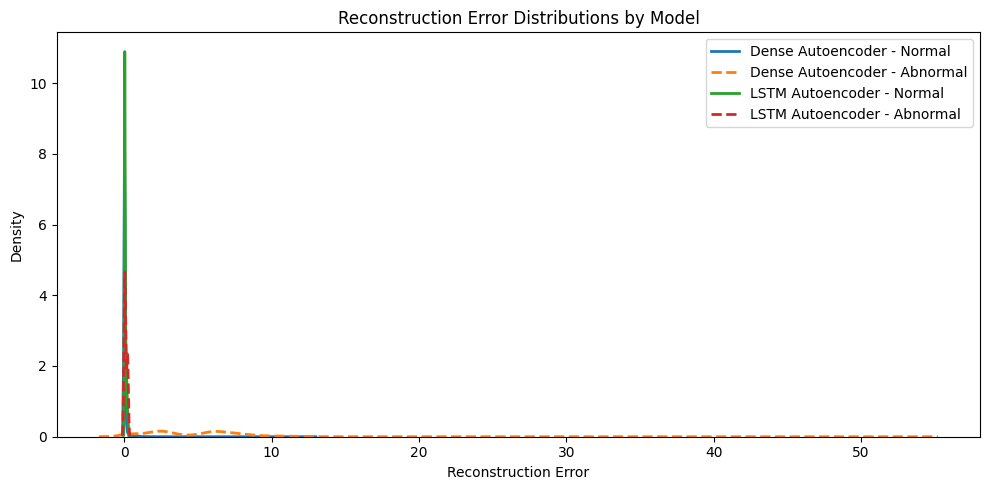

In [5]:
plt.figure(figsize = (10,5))
for model_name, model_dir in model_dirs.items():
    recon_error = np.load(os.path.join(model_dir, "recon_error.npy"))
    y_true = np.load(os.path.join(model_dir, "y_true.npy"))
    sns.kdeplot(recon_error[y_true == 0], label = f"{model_name} - Normal", lw = 2)
    sns.kdeplot(recon_error[y_true == 1], label = f"{model_name} - Abnormal", lw = 2, linestyle = '--')
plt.title("Reconstruction Error Distributions by Model")
plt.xlabel("Reconstruction Error")
plt.legend()
plt.tight_layout()
plt.show()
    

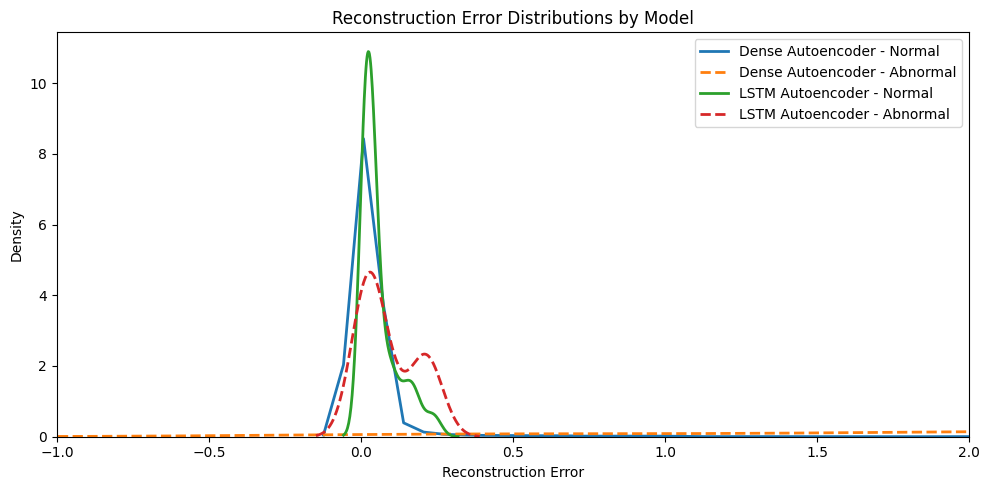

In [6]:
plt.figure(figsize = (10,5))
for model_name, model_dir in model_dirs.items():
    recon_error = np.load(os.path.join(model_dir, "recon_error.npy"))
    y_true = np.load(os.path.join(model_dir, "y_true.npy"))
    sns.kdeplot(recon_error[y_true == 0], label = f"{model_name} - Normal", lw = 2)
    sns.kdeplot(recon_error[y_true == 1], label = f"{model_name} - Abnormal", lw = 2, linestyle = '--')
plt.title("Reconstruction Error Distributions by Model")
plt.xlabel("Reconstruction Error")
plt.xlim([-1, 2])
plt.legend()
plt.tight_layout()
plt.show()

## Error Analysis

In [7]:
for model_name in ["autoencoder", "lstm"]: 
    y_true, y_pred, metrics = load_model_outputs(model_name)
    analyze_model(model_name.upper(), y_true, y_pred, metrics)

-- AUTOENCODER -- 
F1 Score: 0.9615 | ROC AUC: 0.9954 | PR AUC: 0.9921
Confusion Matrix:
TP=4228, FP = 274, FN = 65, TN = 6167
              precision    recall  f1-score   support

      Normal       0.99      0.96      0.97      6441
    Abnormal       0.94      0.98      0.96      4293

    accuracy                           0.97     10734
   macro avg       0.96      0.97      0.97     10734
weighted avg       0.97      0.97      0.97     10734


-- LSTM -- 
F1 Score: 0.3478 | ROC AUC: 0.6039 | PR AUC: 0.1417
Confusion Matrix:
TP=4, FP = 6, FN = 9, TN = 141
              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95       147
    Abnormal       0.40      0.31      0.35        13

    accuracy                           0.91       160
   macro avg       0.67      0.63      0.65       160
weighted avg       0.90      0.91      0.90       160




In [8]:
error_cases = {}
for model_name, output in model_outputs.items():
    recon_error = output["recon_error"]
    y_true = output['y_true']
    threshold = output['threshold']
    y_pred = recon_error >= threshold

    # identify misclassification
    fn_indices = np.where((y_true == 1) & (y_pred == 0))[0] # missed anomaly
    fp_indices = np.where((y_true == 0) & (y_pred == 1))[0] # false alarm

    error_cases[model_name] = {
        "false_negatives": fn_indices,
        "false_positives": fp_indices
    }

In [9]:
print("\nError Analysis Summary:")
for model_name, errs in error_cases.items():
    print(f"{model_name}: {len(errs['false_negatives'])} FN, {len(errs['false_positives'])} FP")


Error Analysis Summary:
Dense Autoencoder: 65 FN, 274 FP
LSTM Autoencoder: 9 FN, 6 FP
